<a href="https://colab.research.google.com/github/NakshatraDigala/Prodigy-tasks/blob/main/Prodigy_cGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import requests
import zipfile

# Download the dataset
dataset_url = "http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz"
dataset_dir = tf.keras.utils.get_file("facades.tar.gz", origin=dataset_url, extract=True)

# Get the path where it was extracted
path = pathlib.Path(dataset_dir).with_suffix("")  # removes .tar.gz
print("Dataset extracted to:", path)


Dataset extracted to: /root/.keras/datasets/facades_extracted


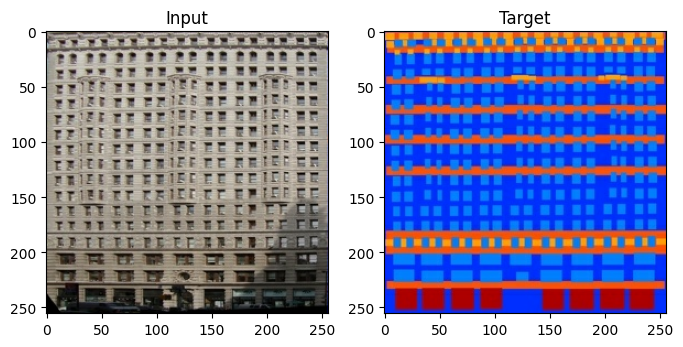

In [ ]:
import glob
import matplotlib.pyplot as plt

def load_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    # Split image into input (real) and target (edge)
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, :w, :]
    target_image = image[:, w:, :]

    # Resize and normalize to [-1, 1]
    input_image = tf.image.resize(input_image, [256, 256])
    target_image = tf.image.resize(target_image, [256, 256])

    input_image = (tf.cast(input_image, tf.float32) / 127.5) - 1
    target_image = (tf.cast(target_image, tf.float32) / 127.5) - 1

    return input_image, target_image

def load_dataset(path_pattern):
    files = glob.glob(path_pattern)
    dataset = tf.data.Dataset.from_tensor_slices(files)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1)
    return dataset

# Load training and test datasets
train_dataset = load_dataset(str(path / "facades" / "train" / "*.jpg"))
test_dataset = load_dataset(str(path / "facades" / "test" / "*.jpg"))

# Check a sample
for input_image, target_image in train_dataset.take(1):
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow((input_image[0] + 1) / 2)
    plt.title("Input")
    plt.subplot(1,2,2)
    plt.imshow((target_image[0] + 1) / 2)
    plt.title("Target")
    plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        layers.Conv2D(filters, size, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(layers.BatchNormalization())

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        layers.Conv2DTranspose(filters, size, strides=2,
                               padding='same',
                               kernel_initializer=initializer,
                               use_bias=False))

    result.add(layers.BatchNormalization())

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

def Generator():
    inputs = layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),                        # (bs, 64, 64, 128)
        downsample(256, 4),                        # (bs, 32, 32, 256)
        downsample(512, 4),                        # (bs, 16, 16, 512)
        downsample(512, 4),                        # (bs, 8, 8, 512)
        downsample(512, 4),                        # (bs, 4, 4, 512)
        downsample(512, 4),                        # (bs, 2, 2, 512)
        downsample(512, 4),                        # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),      # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),      # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),      # (bs, 8, 8, 1024)
        upsample(512, 4),                          # (bs, 16, 16, 1024)
        upsample(256, 4),                          # (bs, 32, 32, 512)
        upsample(128, 4),                          # (bs, 64, 64, 256)
        upsample(64, 4),                           # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')  # (bs, 256, 256, 3)

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

generator = Generator()


In [ ]:
import matplotlib.pyplot as plt

def generate_images(model, input_image, target):
    prediction = model(input_image, training=True)
    plt.figure(figsize=(15, 5))

    display_list = [input_image[0], target[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] + 1) / 2)  # de-normalize [-1,1] to [0,1]
        plt.axis('off')
    plt.show()


In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    tar = layers.Input(shape=[256, 256, 3], name='target_image')

    x = layers.concatenate([inp, tar])  # (bs, 256, 256, 6)

    down1 = downsample(64, 4, False)(x)    # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)      # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)      # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    batchnorm1 = layers.BatchNormalization()(conv)

    leaky_relu = layers.LeakyReLU()(batchnorm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()


In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (100 * l1_loss)
    return total_gen_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [ ]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))



Epoch 1/5
  step 20/100
  step 40/100
  step 60/100
  step 80/100
  step 100/100


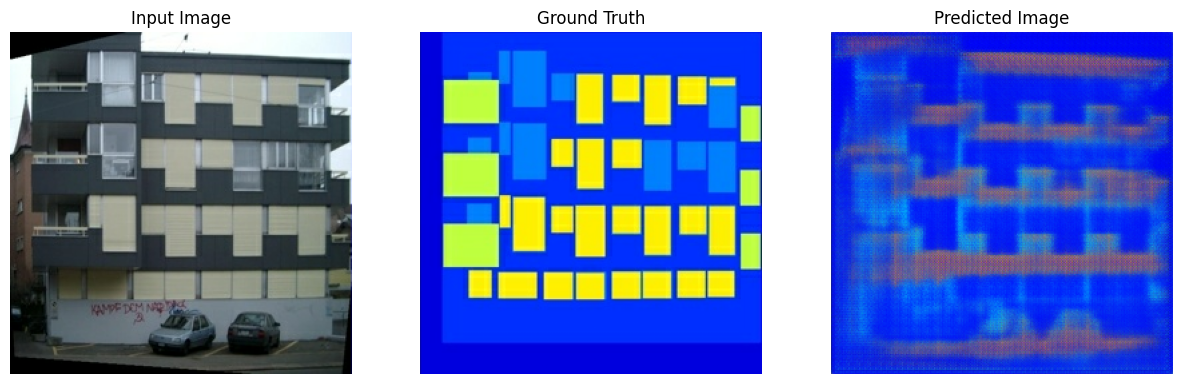


Epoch 2/5
  step 20/100
  step 40/100
  step 60/100
  step 80/100
  step 100/100


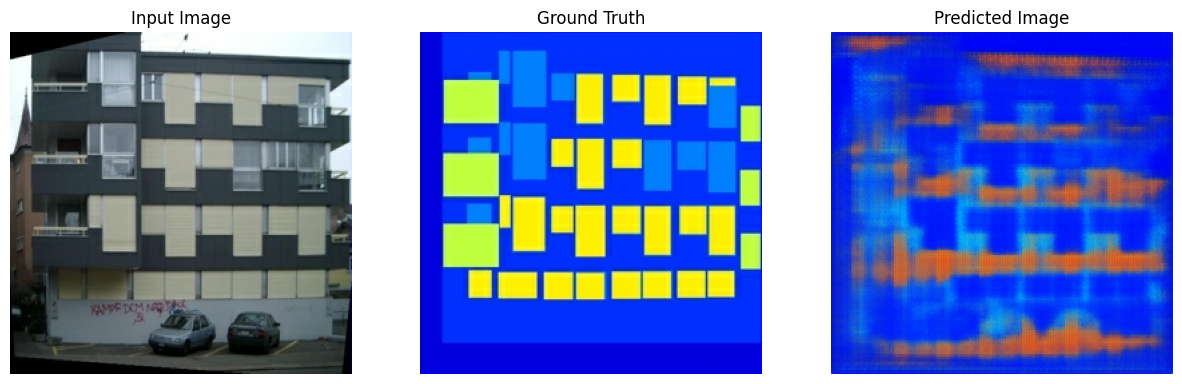


Epoch 3/5
  step 20/100
  step 40/100
  step 60/100
  step 80/100
  step 100/100


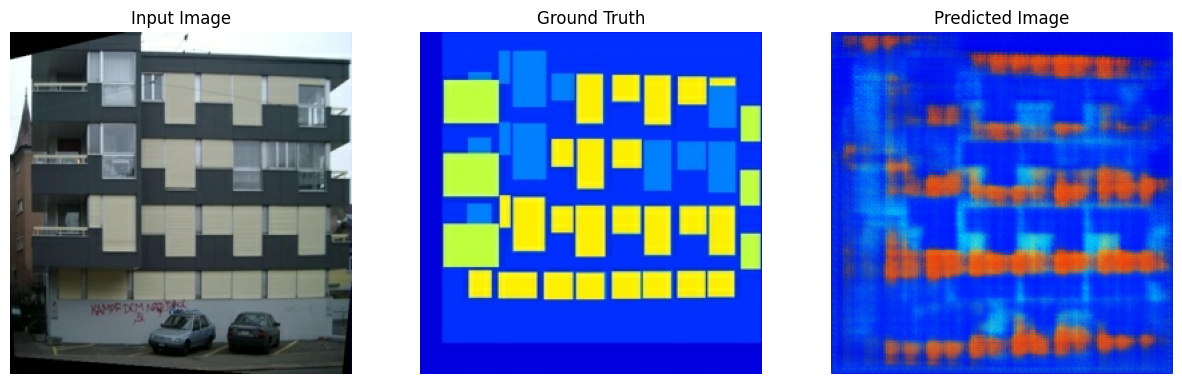


Epoch 4/5
  step 20/100
  step 40/100
  step 60/100
  step 80/100
  step 100/100


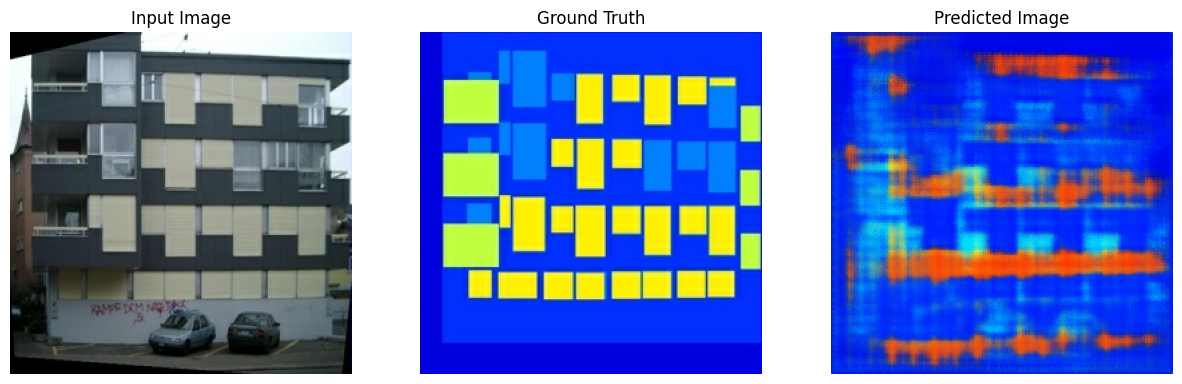


Epoch 5/5
  step 20/100
  step 40/100
  step 60/100
  step 80/100
  step 100/100


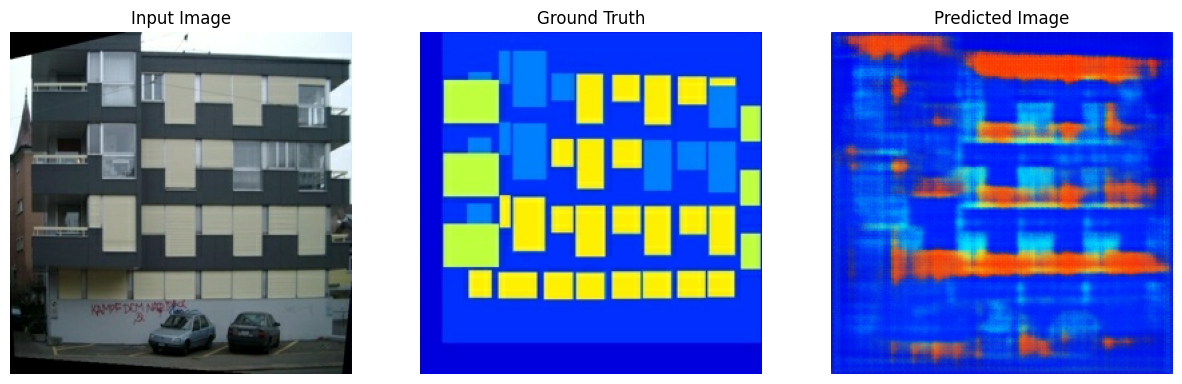

In [ ]:
EPOCHS = 5
STEPS_PER_EPOCH = 100  # Limits training steps per epoch

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    for step, (input_image, target) in train_dataset.take(STEPS_PER_EPOCH).enumerate():
        train_step(input_image, target)
        if (step + 1) % 20 == 0:
            print(f"  step {step+1}/{STEPS_PER_EPOCH}")

    # Show 1 prediction after each epoch
    for example_input, example_target in test_dataset.take(1):
        generate_images(generator, example_input, example_target)
